# Surprisingly effective classification using only embeddings and linear algebra

Embeddings are super cheap and easily available. They are extremely effective at encoding rich information into dense vectors of a fixed size. This allows semantic similarity to be captured in the geometry of the vector space. Meaning that two vectors are close together if their meanings are similar, for example the vectors for "cat" and "dog" are close together. Similarly, an embedding for an image of a falcon and an image of an owl should be close together.

One naive approach to text classification is to use the cosine similarity between the embeddings of the input text and the embeddings of each class.

Let's look at this in detail.


In [2]:
import json

with open("examples.jsonl", "r") as f:
    examples = [json.loads(line) for line in f]

print(f"Number of examples: {len(examples)}")

for example in examples[0:5]:
    print(example)


Number of examples: 677
{'text': 'Nairobi National Park', 'label': 'location'}
{'text': 'Stephen Hawking', 'label': 'person'}
{'text': 'Local Concert', 'label': 'event'}
{'text': 'Pen', 'label': 'object'}
{'text': 'Mila Kunis', 'label': 'person'}


Here we have a basic dataset of 677 examples of nouns. Each example has a label from a set of 5 classes: animal, location, object, person, event. The task is to predict the label of a given example.

In [3]:
# Create train and test sets

from sklearn.model_selection import train_test_split

# Split examples into train and test sets, stratifying by label to maintain class distribution
train_examples, test_examples = train_test_split(
    examples,
    test_size=0.2, 
    random_state=42,
    stratify=[example["label"] for example in examples]
)

print(len(train_examples), len(test_examples))

541 136


In [4]:
CLASSES = ["animal", "location", "object", "person", "event"]

In [5]:
import numpy as np
import openai

client = openai.OpenAI()

# Helper functions

def create_embeddings(examples) -> np.ndarray:
    embeddings = client.embeddings.create(input=examples, model="text-embedding-3-small")
    return np.array([embedding.embedding for embedding in embeddings.data])


def calculate_cosine_similarity(embedding_1, embedding_2):
    return np.dot(embedding_1, embedding_2) / (np.linalg.norm(embedding_1) * np.linalg.norm(embedding_2))

In [6]:
UNIQUE_CLASS_EMBEDDINGS = create_embeddings(CLASSES)

In [7]:
train_input_embeddings = create_embeddings([example["text"] for example in train_examples])
test_input_embeddings = create_embeddings([example["text"] for example in test_examples])

train_labels = [example["label"] for example in train_examples]
test_labels = [example["label"] for example in test_examples]

train_class_embeddings = create_embeddings(train_labels)
test_class_embeddings = create_embeddings(test_labels)



# Naive approach : Direct similarity of embedding vectors

This is a zero-shot approach to classification. We are not using any of the training data, we are just using the embeddings directly.

In [8]:
def classify_example(input_embedding):
    similarities = [calculate_cosine_similarity(input_embedding, class_embedding) for class_embedding in UNIQUE_CLASS_EMBEDDINGS]
    return np.argmax(similarities)

In [9]:
train_results = [classify_example(train_input_embeddings[i]) == CLASSES.index(train_labels[i]) for i in range(len(train_examples))]
print("Train accuracy:", np.mean(train_results))

results = []
print("Direct projection classification errors:")

for i, (embedding, label) in enumerate(zip(test_input_embeddings, test_labels)):
    prediction = classify_example(embedding)
    label_idx = CLASSES.index(label)
    correct =  classify_example(embedding) == label_idx
    results.append(correct)
    if not correct:
        print(test_examples[i]["text"], ":", label, "->", CLASSES[prediction])


print("\nTest accuracy:", np.mean(results))


Train accuracy: 0.8133086876155268
Direct projection classification errors:
Drone : object -> animal
Ant : animal -> object
Frying Pan : object -> person
Rhino : animal -> object
Gavel : object -> event
Nile River : location -> animal
Sledge : object -> animal
Falconry : event -> animal
Ariana Grande : person -> animal
Eiffel Tower : location -> event
Nail Clippers : object -> animal
Photography Contest : event -> person
The Great Wall : location -> person
Kilimanjaro : location -> event
Chicago : location -> animal
Milan Cathedral : location -> object
Wireless Charger : object -> location
Pillow : object -> person
Victoria Falls : location -> event
Albert Einstein : person -> object
Gazelle : animal -> object
Waffle Maker : object -> event
Art Class : event -> object
Nice : location -> object
Leonardo da Vinci : person -> object

Test accuracy: 0.8161764705882353


Eyeballing these results, we can see that the naive embedding overlap approach is making some very obvious mistakes. Using this approach could be a disaster in a real-world application. However, given that it is totally parameter-free, it forms a useful baseline and might be useful in some low-risk application (e.g. recommendation systems, personal organising).


# An SVD approach

Now, we can use the properties of embeddings and the singular value decomposition (SVD) to get better results. We will find the optimal rotation matrix that best aligns the input embeddings with the class embeddings, then calculate the cosine similarity of the rotated input embeddings with the class embeddings.

## How can we find the optimal rotation matrix?

We want to find the rotation matrix $M$ that best aligns the input embeddings $X$ with the class embeddings $Y$, such that:

$Mx≈y$

We can phrase this as a least squares problem:

$M = \text{argmin} ||MX - Y||_F$

Where $||.||_F$ is the Frobenius norm (i.e. the sum of the squares of the elements) 

$X \in \mathbb{R}^{d \times n}$ : Source embedding matrix.

$Y \in \mathbb{R}^{d \times n}$ : Target embedding matrix.

$M \in \mathbb{R}^{d \times d}$ : Some transformation matrix.

If you expand the trace out, and impose the constraint that $M$ is orthogonal ($M^TM = I$) and keep only the terms that depend on $M$, then this simplifies to:

$||MX - Y||_F^2 = - 2Tr(X^TM^TY)$

which means that minimising the least squares error is equivalent to maximising $Tr(X^TM^TY)$.

Now, let $C = YX^T$, then we can use the permutation property of the trace, we are now seeking to maximise $Tr(MC)$

$C \in \mathbb{R}^{n \times n}$ : Cross-covariance matrix between $X$ and $Y$.

If $C_{ij}$ is large (positive or negative), then the $i\text{th}$ element of $Y$ and $j\text{th}$ element of $X$ are strongly correlated. Conversely, if $C_{ij}$ is close to zero, then there is little correlation between these elements. Geometrically, column vectors of $C$ correspond to how one dimension of the input embedding space $X$ aligns with all dimensions of the class embedding space $Y$.

Now, since the two sets of embeddings are technically from the same embedding space, in the limit that $X$ and $Y$ are the same, $C$ will be the identity matrix. But in our case, $X$ and $Y$ are very specific sets of embeddings, and so $C$ will be non-trivial.

Now for the fun part. We can use the Singular Value Decomposition (SVD) to decompose $C$ as:

$C = U\Sigma V^T$

Here we're supposing that we can diagonalise $C$ by finding the following matrices:

$U \in \mathbb{R}^{n \times n}$ : Orthogonal matrix of left singular vectors. These are the orthogonal basis vectors of the input embedding space.

$V \in \mathbb{R}^{n \times n}$ : Orthogonal matrix of right singular vectors. These are the orthogonal basis vectors of the class embedding space.

$\Sigma \in \mathbb{R}^{n \times n}$ : Diagonal matrix of singular values. These values indicate the magnitude of the variance of the input embedding space that is captured by each of the basis vectors in the class embedding space (we will return to this later to get better intuition).

Substituting this into our earlier loss function, we get:

$Tr(M^TC) = Tr(M^TU\Sigma V^T)$

Now we define an orthogonal matrix $Q = M^TU$, ($Q^TQ = I$) then we can rewrite this as:

$Tr(M^TU\Sigma V^T) = Tr(\Sigma V^TQ)$

Since both $V^T$ and $Q$ are orthogonal and $\Sigma$ is diagonal, the maximum value of this trace is achieved when $V^TQ = I$, which means $Q = V^T$.

Therefore, the optimal rotation matrix $M$ is given by $M = U V^T$.

This means we can find the optimal rotation matrix that maps the input embeddings to the class embeddings by finding the SVD of their cross-covariance matrix. Let's see if this works.

In [30]:
import time
import torch

CLASSES_EMBEDDINGS = torch.FloatTensor(UNIQUE_CLASS_EMBEDDINGS)


def run_svd(num_examples=None):
    if num_examples is None:
        num_examples = len(train_input_embeddings)

    X = torch.FloatTensor(train_input_embeddings[:num_examples])
    
    target_embeddings = CLASSES_EMBEDDINGS[
        torch.LongTensor(
            [CLASSES.index(label) for label in train_labels[:num_examples]]
        )
    ]
    C = target_embeddings.T @ X

    return torch.linalg.svd(C)


def classify_with_matrices(embedding, U, Vh):
    if not isinstance(embedding, torch.FloatTensor):
        embedding = torch.FloatTensor(embedding)
    if embedding.ndim == 1:
        embedding = embedding.unsqueeze(0)

    transformed = U @ Vh @ embedding.T
    similarities = torch.nn.functional.cosine_similarity(
        transformed.T.unsqueeze(1), CLASSES_EMBEDDINGS.unsqueeze(0), dim=2
    )
    return similarities.argmax().item()


U, S, Vh = run_svd()

ti = time.time()
results = []
print("Misclassifications:")
for i, example in enumerate(test_examples):
    prediction = classify_with_matrices(test_input_embeddings[i], U, Vh)
    correct = prediction == CLASSES.index(example["label"])
    results.append(correct)
    if not correct:
        print(f"{example['text']}: {example['label']} -> {CLASSES[prediction]}")

accuracy = np.mean(results)
print()
print(f"Accuracy: {accuracy}")
print(f"Inference time: {time.time() - ti}s")
print("Shape of U:", U.shape)
print("Shape of Vh:", Vh.shape)
print("Shape of M:", (U @ Vh).shape)
print("Total parameters of M:", U.numel())

Misclassifications:
Ant: animal -> person
Falconry: event -> animal
Nice: location -> object

Accuracy: 0.9779411764705882
Inference time: 0.70833420753479s
Shape of U: torch.Size([1536, 1536])
Shape of Vh: torch.Size([1536, 1536])
Shape of M: torch.Size([1536, 1536])
Total parameters of M: 2359296


Okay, it works really well. We've reduced our error rate from 18.4% to 2.2%! Now that we've got that dopamine hit, let's get a better understanding of what the SVD is doing. Because there are more dopamine hits to be had!

As we saw earlier, the columns of $V$ are a set of orthogonal basis vectors of the class embedding space. The columns of $U$ are a set of orthogonal basis vectors for the input embedding space. Each of the elements of $C$ is a dot product between a row of $V$ and a column of $X$ like:

$C_{ij} = \Sigma_i \vec{V}_i \cdot \vec{X}_j$ 

Where $\Sigma_i$ is the $i\text{th}$ element of the diagonal matrix $\Sigma$, and $\vec{V}_i$ and $\vec{X}_j$ are the $i\text{th}$ column of $V$ and the $j\text{th}$ column of $X$ respectively. In effect, $\Sigma_i$ is telling us how important the $i\text{th}$ basis vector of the class embedding space is in determining the $j\text{th}$ basis vector of the input embedding space. This means that we can inspect the elements of $\Sigma$, to see which vectors are actually contributing to the transformation.

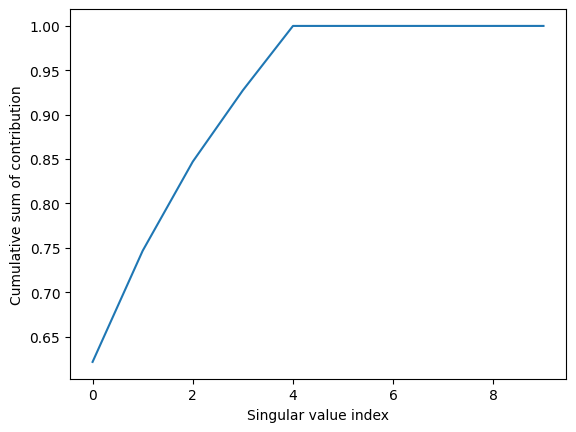

In [31]:
import matplotlib.pyplot as plt

S_norm = S / S.sum()
max_components = 10
plt.plot(range(0, max_components),np.cumsum(S_norm)[0:max_components])
plt.xlabel("Singular value index")
plt.ylabel("Cumulative sum of contribution")
plt.show()


We can see that only the first 5 singular values are contributing significantly to the transformation. This makes sense, as there are only 5 class labels, so you might expect that only 5 dimensions are actually needed to capture the variation in the class embeddings. This means that we can get a good approximation of the transformation by only considering the first 5 basis vectors of the class embedding space. Correspondingly, we will only need 5 basis vectors of the input embedding space so that we can transform them into the same space.

In [43]:
num_components = 5
U_compressed = U[:, :num_components]
Vh_compressed = Vh[:num_components, :]
M_compressed = U_compressed @ Vh_compressed
print(U_compressed.shape)
print(Vh_compressed.shape)
print(M_compressed.shape)

torch.Size([1536, 5])
torch.Size([5, 1536])
torch.Size([1536, 1536])


In [46]:
print("Training misclassifications:")
results = []
for i, example in enumerate(train_examples):
    prediction = classify_with_matrices(train_input_embeddings[i], U_compressed, Vh_compressed)
    correct = prediction == CLASSES.index(train_labels[i])
    results.append(correct)
    if not correct:
        print(f"{example['text']}: {example['label']} -> {CLASSES[prediction]}")

accuracy = np.mean(results)
print(f"Train accuracy: {accuracy}")

print()
print("Testing misclassifications:")
ti = time.time()
results = []
for i, example in enumerate(test_examples):
    prediction = classify_with_matrices(test_input_embeddings[i], U_compressed, Vh_compressed)
    correct = prediction == CLASSES.index(example["label"])
    results.append(correct)
    if not correct:
        print(f"{example['text']}: {example['label']} -> {CLASSES[prediction]}")

accuracy = np.mean(results)
print(f"Accuracy: {accuracy}")
print(f"Inference time: {time.time() - ti}s")
print()
print("Shape of U_compressed:", U_compressed.shape)
print("Shape of Vh_compressed:", Vh_compressed.shape)
print("Shape of M_compressed:", (U_compressed @ Vh_compressed).shape)
print("Total parameters of U and Vh:", U_compressed.numel() + Vh_compressed.numel())
print("Reduction factor in parameters:",  U.numel() / (U_compressed.numel() + Vh_compressed.numel()))

Training misclassifications:
Technology Workshop: event -> object
Big Ben: location -> person
Pottery Class: event -> object
Python: animal -> object
Cheetah Prints: object -> animal
Bouquet: object -> event
Big Sur: location -> object
Newt: animal -> person
Train accuracy: 0.9852125693160814

Testing misclassifications:
Ant: animal -> person
Falconry: event -> animal
Nice: location -> object
Accuracy: 0.9779411764705882
Inference time: 0.02179884910583496s

Shape of U_compressed: torch.Size([1536, 5])
Shape of Vh_compressed: torch.Size([5, 1536])
Shape of M_compressed: torch.Size([1536, 1536])
Total parameters of U and Vh: 15360
Reduction factor in parameters: 153.6


So, by removing the less important dimensions, we've reduced the number of parameters in our model by a factor of 154 without any loss of accuracy. We have also reduced the inference time by around 19x.

The errors now look much more feasible too:

```
Ant: animal -> person
Falconry: event -> animal
Nice: location -> object
```

- Ant (capitalised) is technically a person's name.
- Falconry is an event, but it's name is so similar to the animal and so rare that its misclassification is understandable. It's probably tokenised as "falcon" + "ry".
- Nice is a location, but it's name is so similar to the adjective (which is much more common) that its misclassification is understandable without any additional context.

We can also see that the accuracy on the training set is 98.5% for 6 components. This indicates that the SVD approach is not overfitting, given by the small difference between the training and test accuracy. This is a good sign as we would like the approach to generalise well.

## Analyse the principal components

We can also analyse the principal components to see how each class aligns with each component.

/var/folders/8r/43s7kjn14dvb88twkg_tx5h00000gn/T/ipykernel_47740/1462374276.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  input_transformed = Vh_compressed @ input_embeddings.T # (num_components, num_examples)
/var/folders/8r/43s7kjn14dvb88twkg_tx5h00000gn/T/ipykernel_47740/1462374276.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(1, len(classes_transformed) + 1), np.abs(classes_transformed), label=CLASSES)


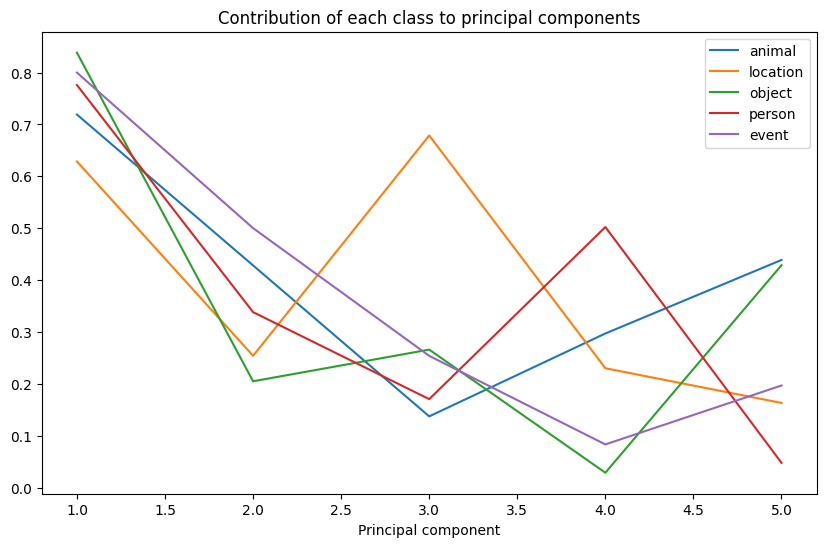

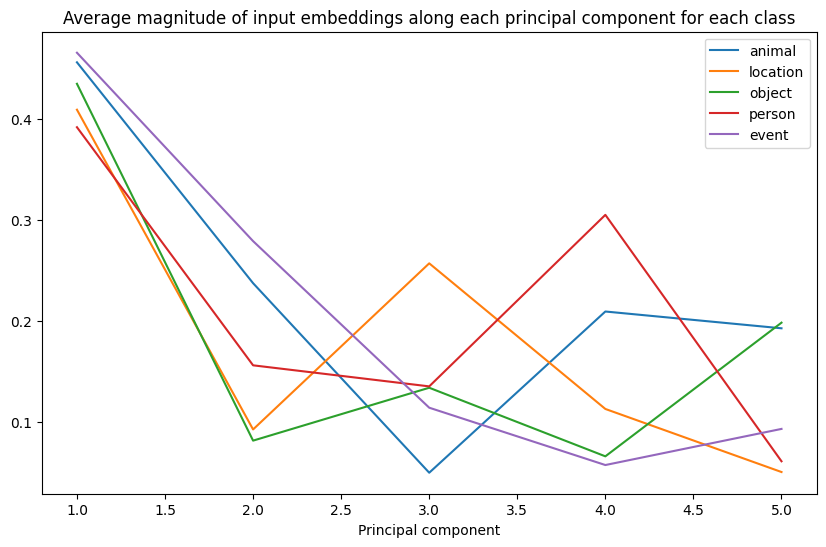


Class: animal
Dominant component: 2
Magnitudes per component: [0.45576431 0.2371963  0.04964235 0.20917271 0.19255704]

Class: location
Dominant component: 3
Magnitudes per component: [0.40886916 0.09246922 0.25683335 0.11274269 0.05033502]

Class: object
Dominant component: 5
Magnitudes per component: [0.43451231 0.08139995 0.13373179 0.06585872 0.19812579]

Class: person
Dominant component: 4
Magnitudes per component: [0.39153534 0.15592095 0.13508355 0.30480942 0.06096541]

Class: event
Dominant component: 2
Magnitudes per component: [0.46525308 0.27882152 0.11398465 0.05724817 0.09299641]


In [49]:
def align_classes_to_components(input_embeddings, labels):
    """Analyze how different classes align with principal components"""
    
    # Transform the input embeddings X into the principal component space of X.
    # Each row corresponds to the magnitude of input embeddings along that principal axis in X.
    input_transformed = Vh_compressed @ input_embeddings.T # (num_components, num_examples)
    
    # Each row corresponds to the magnitude of class embeddings along that principal axis in Y.
    classes_transformed = U_compressed.T @ CLASSES_EMBEDDINGS.T # (num_components, num_classes)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(classes_transformed) + 1), np.abs(classes_transformed), label=CLASSES)
    plt.title("Contribution of each class to principal components")
    plt.xlabel("Principal component")
    plt.legend()
    plt.show()

    class_alignments = {}
    
    if torch.is_tensor(input_transformed):
        input_transformed = input_transformed.numpy()
        
    plt.figure(figsize=(10, 6))
    plt.title("Average magnitude of input embeddings along each principal component for each class")
    plt.xlabel("Principal component")
    for class_name in CLASSES:
        class_indices = [i for i, label in enumerate(labels) if label == class_name]
        class_embeddings = input_transformed[:, class_indices]

        # Calculate average magnitude along each component
        component_magnitudes = np.abs(class_embeddings).mean(axis=1)
        plt.plot(range(1, len(component_magnitudes) + 1), component_magnitudes, label=class_name)
        # Store the dominant component (highest magnitude, excluding the first component which is uninformative)
        dominant_component = np.argmax(component_magnitudes[1:])
        class_alignments[class_name] = {
            'dominant_component': dominant_component + 2,
            'magnitude_per_component': component_magnitudes
        }
    plt.legend()
    plt.show()
    return class_alignments


alignments = align_classes_to_components(train_input_embeddings, train_labels)


for class_name, alignment in alignments.items():
    print(f"\nClass: {class_name}")
    print(f"Dominant component: {alignment['dominant_component']}")
    print("Magnitudes per component:", alignment['magnitude_per_component'])

The first component explains over 60% of the variation of the data, and I imagine vectors along this axis contain some abstract property of "noun-ness", which is why it's so strongly correlated with all of the class embeddings. We can see that the other components are much less consistent, and so the classes must not be very orthogonal in the total embedding space (i.e. not linearly separable). The only exceptions are principal components 2 and 3, which seem to capture a bit of "locationness" and "personness" (or perhaps "beingness"), respectively.


# Bonus: Linear neural network

We will now remove the orthogonality constraint and train a linear classifier on the embeddings (without a bias term).


In [50]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# Define the neural network
class LinearClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim, bias=False)
        self.register_buffer(
            "output_proj", torch.FloatTensor(UNIQUE_CLASS_EMBEDDINGS), persistent=False
        )

    def forward(self, x):
        output = self.linear(x)
        output = output @ self.output_proj.T
        return output


# Create dataset class
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor([CLASSES.index(label) for label in labels])

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


# Input embeddings: each row is an embedding of length 1536
dataset = EmbeddingDataset(train_input_embeddings, train_labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
model = LinearClassifier(input_dim=train_input_embeddings.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 1000
prev_loss = 1e10
tol = 1e-3
for epoch in range(num_epochs):
    total_loss = 0
    for batch_embeddings, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")
        if abs(total_loss - prev_loss) < tol:
            print("Loss converged, stopping early")
            break
        prev_loss = total_loss


def classify_example_with_nn(embedding):
    model.eval()
    with torch.no_grad():
        output = model(torch.FloatTensor(embedding))
        return torch.argmax(output).item()

results = []
for i, example in enumerate(train_examples):
    prediction = classify_example_with_nn(train_input_embeddings[i])
    results.append(prediction == CLASSES.index(train_labels[i]))
    
print("Train accuracy:", np.mean(results))

print("\nTesting on examples:")
results = []
for i, example in enumerate(test_examples):
    prediction = classify_example_with_nn(test_input_embeddings[i])
    correct = prediction == CLASSES.index(example["label"])
    results.append(correct)
    if not correct:
        print(f"{example['text']}: {example['label']} -> {CLASSES[prediction]}")

print("Accuracy:", np.mean(results))

Epoch [10/1000], Loss: 0.0140
Epoch [20/1000], Loss: 0.0044
Epoch [30/1000], Loss: 0.0022
Epoch [40/1000], Loss: 0.0012
Epoch [50/1000], Loss: 0.0008
Epoch [60/1000], Loss: 0.0005
Epoch [70/1000], Loss: 0.0003
Epoch [80/1000], Loss: 0.0002
Epoch [90/1000], Loss: 0.0002
Epoch [100/1000], Loss: 0.0001
Epoch [110/1000], Loss: 0.0001
Epoch [120/1000], Loss: 0.0001
Epoch [130/1000], Loss: 0.0000
Epoch [140/1000], Loss: 0.0000
Loss converged, stopping early
Train accuracy: 1.0

Testing on examples:
Falconry: event -> animal
Gazelle: animal -> object
Nice: location -> object
Accuracy: 0.9779411764705882


Remarkably, this results in the exact same accuracy on the test set. 

It gets Ant correct this time, but still misclassifies Falconry and Nice, as well 

```
Gazelle: animal -> object
```

This is understandable, as Gazelle are also a type of Adidas shoe!


It's interesting to see that the linear NN gets an training accuracy of 100%. This could indicate some overfitting. The nice thing about the rotation matrix approach is that we don't really need to worry about overfitting. There is regularization built-in through the inductive bias of the orthogonal transformation.